In [36]:
import os
import pandas as pd
import numpy as np
from string import digits
import requests
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Attention

In [2]:
classes = os.listdir('./BBC News Summary/News Articles')
Articles_dir = './BBC News Summary/News Articles/'
Summaries_dir = './BBC News Summary/Summaries/'

articles = []
summaries = []
file_arr = []
for cls in classes:
    files = os.listdir(Articles_dir + cls)
    for file in files:
        article_file_path = Articles_dir + cls + '/' + file
        summary_file_path = Summaries_dir + cls + '/' + file
        try:
            with open(article_file_path, 'r') as f:
                articles.append('.'.join(
                    [line.rstrip() for line in f.readlines()]))
            with open(summary_file_path, 'r') as f:
                summaries.append('.'.join(
                    [line.rstrip() for line in f.readlines()]))
            file_arr.append(cls + '/' + file)
        except:
            pass

data = pd.DataFrame({
    'File_path': file_arr,
    'Articles': articles,
    'Summaries': summaries
})
data.head()

,File_path,Articles,Summaries
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ..."
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_path  2225 non-null   object
 1   Articles   2225 non-null   object
 2   Summaries  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [4]:
data.describe()

,File_path,Articles,Summaries
count,2225,2225,2225
unique,2225,2127,2081
top,business/001.txt,Ray DVD beats box office takings..Oscar-nomina...,Although the two partially-paralysed people pe...
freq,1,2,2


In [5]:
# data.to_csv('news.csv')

In [6]:
data.shape

(2225, 3)

In [7]:
contractions_dictionary = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}


In [8]:
def Filter(text):
    text = text.lower()
    text = ' '.join([
        contractions_dictionary[i]
        if i in contractions_dictionary.keys() else i for i in text.split()
    ])
    text = re.sub(r'\(.*\)', "", text)
    text = re.sub("'s", "", text)
    text = re.sub('"', '', text)
    text = ' '.join([i for i in text.split() if i.isalpha()])
    text = re.sub('[^a-zA-Z]', " ", text)

    return text


data['File_path'] = data['File_path'].apply(Filter)
data['Articles'] = data['Articles'].apply(Filter)
data['Summaries'] = data['Summaries'].apply(Filter)

In [9]:
# data = data.drop(['File_path'], axis=1)
data

,File_path,Articles,Summaries
0,,ad sales boost time warner profits at us media...,timewarner said fourth quarter sales rose to f...
1,,dollar gains on greenspan dollar has hit its h...,the dollar has hit its highest level against t...
2,,yukos unit buyer faces loan owners of embattle...,owner menatep group says it will ask rosneft t...
3,,high fuel prices hit ba airways has blamed hig...,rod ba chief said the results were respectable...
4,,pernod takeover talk lifts in uk drinks and fo...,pernod has reduced the debt it took on to fund...
...,...,...,...
2220,,bt program to beat dialler is introducing two ...,bt is introducing two initiatives to help beat...
2221,,spam tempt net users across the world continue...,a third of them read unsolicited junk and buy ...
2222,,be careful how you new european directive coul...,this goes to the heart of the european and eve...
2223,,us cyber security chief man making sure us com...,amit yoran was director of the national cyber ...


In [10]:
# Remove HTML tags from the data frame if they are present


def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


data['Summary'] = data['Summaries'].apply(strip_html)
data['Article'] = data['Articles'].apply(strip_html)

data = data.drop(['Summaries', 'Articles'], axis=1)


In [11]:
data

,File_path,Summary,Article
0,,timewarner said fourth quarter sales rose to f...,ad sales boost time warner profits at us media...
1,,the dollar has hit its highest level against t...,dollar gains on greenspan dollar has hit its h...
2,,owner menatep group says it will ask rosneft t...,yukos unit buyer faces loan owners of embattle...
3,,rod ba chief said the results were respectable...,high fuel prices hit ba airways has blamed hig...
4,,pernod has reduced the debt it took on to fund...,pernod takeover talk lifts in uk drinks and fo...
...,...,...,...
2220,,bt is introducing two initiatives to help beat...,bt program to beat dialler is introducing two ...
2221,,a third of them read unsolicited junk and buy ...,spam tempt net users across the world continue...
2222,,this goes to the heart of the european and eve...,be careful how you new european directive coul...
2223,,amit yoran was director of the national cyber ...,us cyber security chief man making sure us com...


In [12]:
# Remove Stop Words from the Summary


def remove_stopword(text):
    stopword = nltk.corpus.stopwords.words('english')
    stopword.remove('not')
    a = [w for w in nltk.word_tokenize(text) if w not in stopword]
    return ' '.join(a)


data['Summary'] = data['Summary'].apply(remove_stopword)
data['Article'] = data['Article'].apply(remove_stopword)

In [13]:
def punc_clean(text):
    import string as st
    a = [w for w in text if w not in st.punctuation]
    return ''.join(a)


data['Summary'] = data['Summary'].apply(punc_clean)
data['Article'] = data['Article'].apply(punc_clean)

In [14]:
data['cleaned_summary'] = data['Summary'].apply(
    lambda x: '_START_ ' + x + ' _END_')


In [15]:
data['cleaned_summary']

0       _START_ timewarner said fourth quarter sales r...
1       _START_ dollar hit highest level euro almost t...
2       _START_ owner menatep group says ask rosneft r...
3       _START_ rod ba chief said results respectable ...
4       _START_ pernod reduced debt took fund seagram ...
                              ...                        
2220    _START_ bt introducing two initiatives help be...
2221    _START_ third read unsolicited junk buy goods ...
2222    _START_ goes heart european even not care soft...
2223    _START_ amit yoran director national cyber sec...
2224    _START_ says world online gaming behaviour lot...
Name: cleaned_summary, Length: 2225, dtype: object

In [16]:
# data['cleaned_text']=cleaned_text
cleaned_summary = data['cleaned_summary']
data['cleaned_summary'].replace('', np.nan, inplace=True)

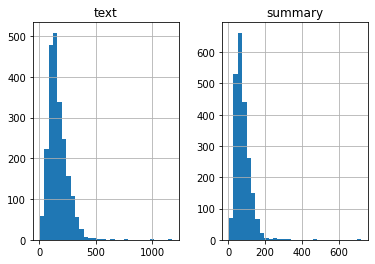

In [17]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['Article']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({
    'text': text_word_count,
    'summary': summary_word_count
})
length_df.hist(bins=30)
plt.show()

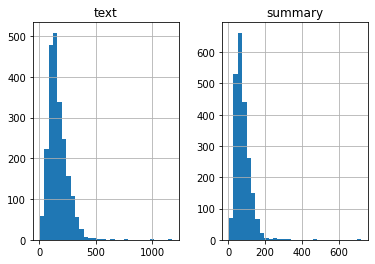

In [18]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['Article']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({
    'text': text_word_count,
    'summary': summary_word_count
})
length_df.hist(bins=30)
plt.show()

In [19]:
max_len_article = 240
max_len_summary = 90


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['Article'],
                                                    data['cleaned_summary'],
                                                    test_size=0.25,
                                                    random_state=0)


In [21]:
# From DeepAI API
r = requests.post("https://api.deepai.org/api/summarization",
                  data={
                      'text':
                      '''Ad sales boost Time Warner profit

                        Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

                        The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

                        Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.

                        Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. "Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility," chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.

                        TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.
                        ''',
                },
                  headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'})
print(r.json())

{'id': '62b3f9cd-832d-44da-89c1-51574701f55b', 'output': "Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\nTimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.\nHowever, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.\nFor the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn."}


In [22]:
# Abstract Tokenizer

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 59.26105979581915
Total Coverage of rare words: 6.873426187508909


In [24]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train_seq = x_tokenizer.texts_to_sequences(X_train) 
X_test_seq = x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(X_train_seq,  maxlen=max_len_article, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_len_article, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [25]:
x_voc

8381

In [26]:
# Summary Tokenizer

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.43015505507613
Total Coverage of rare words: 15.199220159191912


In [28]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

#padding zero upto maximum length
y_train = pad_sequences(y_train_seq, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words +1

In [29]:
y_voc

3788

In [30]:
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train = np.delete(y_train,ind, axis=0)
X_train = np.delete(X_train,ind, axis=0)

In [31]:
ind=[]

for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test = np.delete(y_test,ind, axis=0)
X_test = np.delete(X_test,ind, axis=0)

In [41]:
# Model Building

from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_article,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
# attn_layer = Attention(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
attn_out, attn_states = tf.keras.layers.Attention()(
    [encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

TypeError: Cannot iterate over a Tensor with unknown first dimension.